In [1]:
# Preamble
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib as mpl
import pandas as pd
import numpy as np

from collections import Counter

from utils import load_probs

data = load_probs()
actual = data['actual']
probs = data.drop('actual', axis=1)
data.head()

Classifier,LogisticRegression,GaussianNB,LinearSVC,RandomForestClassifier,SGDClassifier,KNeighborsClassifier,actual
0,0.979908,1.0,0.627873,1.0,0.626272,1.0,True
1,0.968832,1.0,0.574250,1.0,0.631219,1.0,True
2,0.972728,1.0,0.578030,1.0,0.629980,1.0,True
3,0.999986,1.0,0.775335,1.0,0.747994,1.0,True
4,0.815760,1.0,0.574944,1.0,0.549328,1.0,True


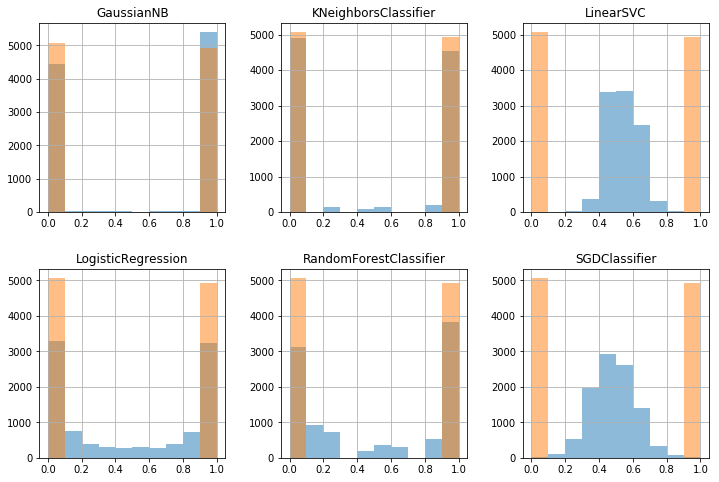

In [2]:
axes = probs.hist(figsize=(12,8), layout=(2,3), alpha=0.5)
for ax in axes.flat:
    actual.hist(ax=ax, alpha=0.5)
plt.show()

In [3]:
probs.apply(lambda x: len(np.unique(x)))

Classifier
LogisticRegression        10000
GaussianNB                 4185
LinearSVC                 10000
RandomForestClassifier       11
SGDClassifier             10000
KNeighborsClassifier          6
dtype: int64

In [4]:
def gen_datagram(prob, actual, bins=100):
    width = bins + 1
    bins, step = np.linspace(0., 1., width, retstep=True)
    idx = np.digitize(prob, bins) - 1
    top = np.bincount(idx, weights=actual, minlength=width)
    bot = np.bincount(idx, weights=(~actual), minlength=width)
    return top, bot, bins, step

In [5]:
def draw_datagram(prob, actual, bins=100, ax=None):
    top, bot, bins, bin_width = gen_datagram(prob, actual, bins=bins)
    if ax is None:
        fig = plt.gcf()
        ax = fig.add_subplot(111)
    ax.axhline(linestyle='dashed', color='black', alpha=0.2)
    ax.axvline(x=0.5, linestyle='dashed', color='black', alpha=0.2)
    ax.bar(bins, top, width=bin_width)
    ax.bar(bins, -bot, width=bin_width)
    height = max(abs(x) for x in ax.get_ylim())
    ax.set_ylim([-height, height])
    return ax

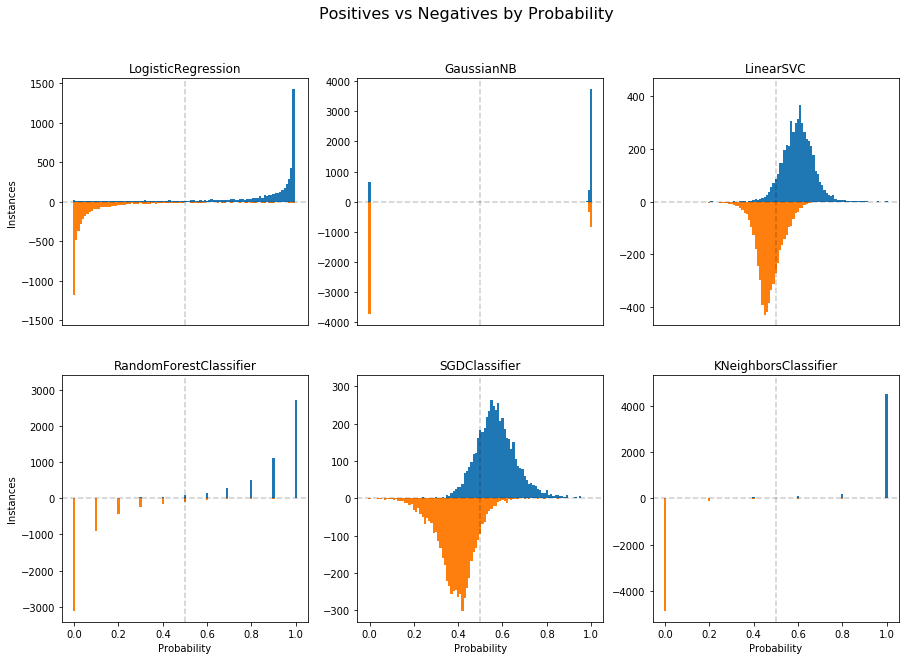

In [6]:
fig, axes = plt.subplots(nrows=2, ncols=3, sharex=True, figsize=(15, 10))
axes = tuple(axes.flat)

for ax, (label, prob) in zip(axes, probs.iteritems()):
    draw_datagram(prob.copy(), actual, ax=ax)
    ax.set_title(label)

fig.suptitle('Positives vs Negatives by Probability', fontsize=16)
axes[0].set_ylabel('Instances')
axes[3].set_ylabel('Instances')

for x in (0, 1, 2):
    axes[x].xaxis.set_ticks_position('none')
axes[3].set_xlabel('Probability')
axes[4].set_xlabel('Probability')
axes[5].set_xlabel('Probability')

# plt.tight_layout()
plt.show()

### Randomness

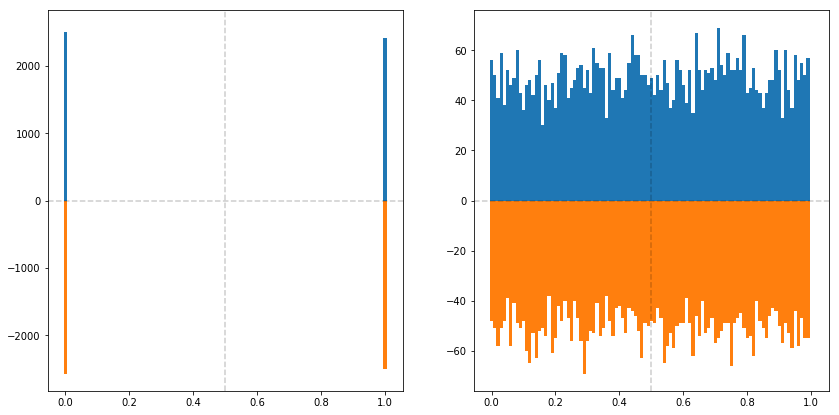

In [7]:
_, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(14,7))

discrete = np.random.randint(2, size=10_000)
uniform = np.random.uniform(size=10_000)

draw_datagram(discrete, actual, ax=ax1)
draw_datagram(uniform, actual, ax=ax2)

plt.show()

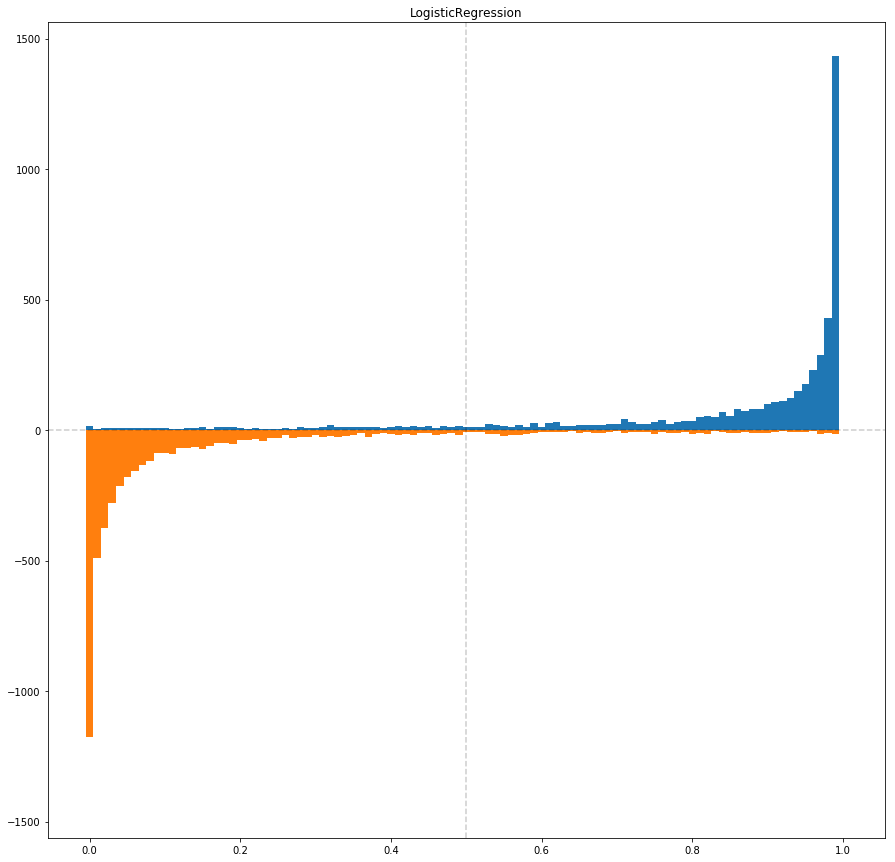

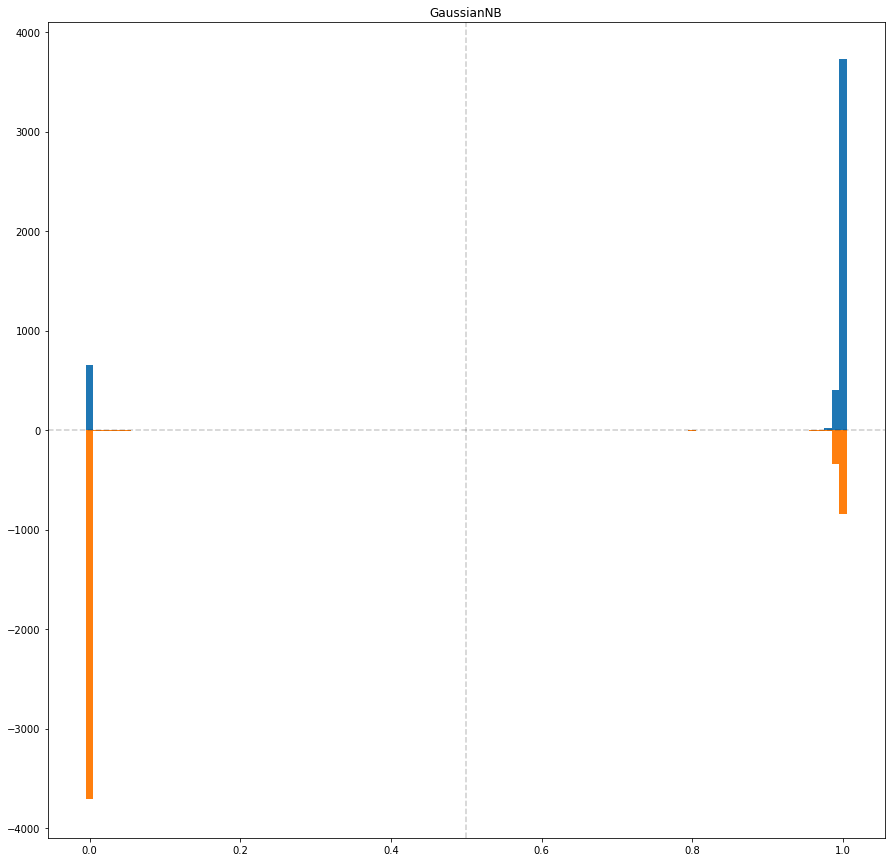

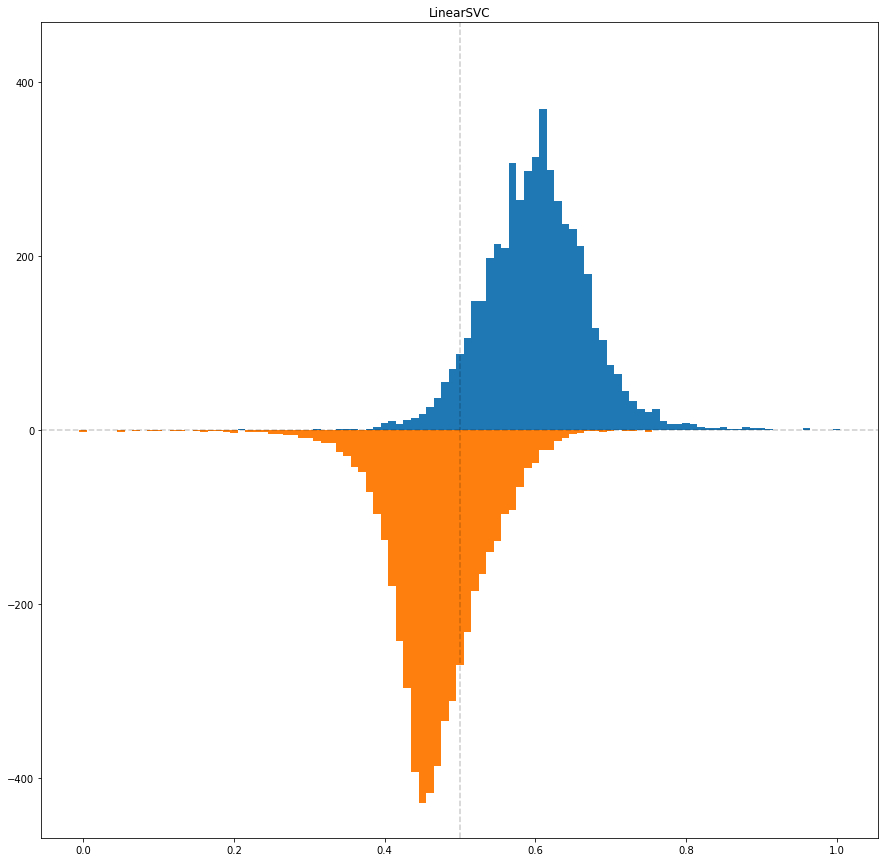

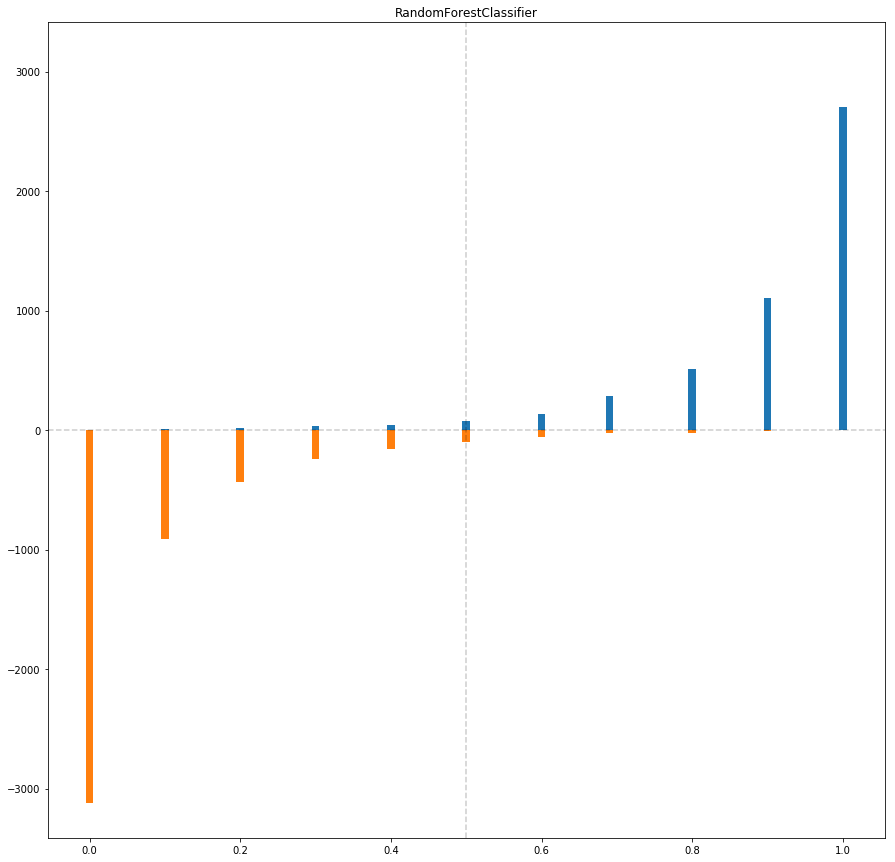

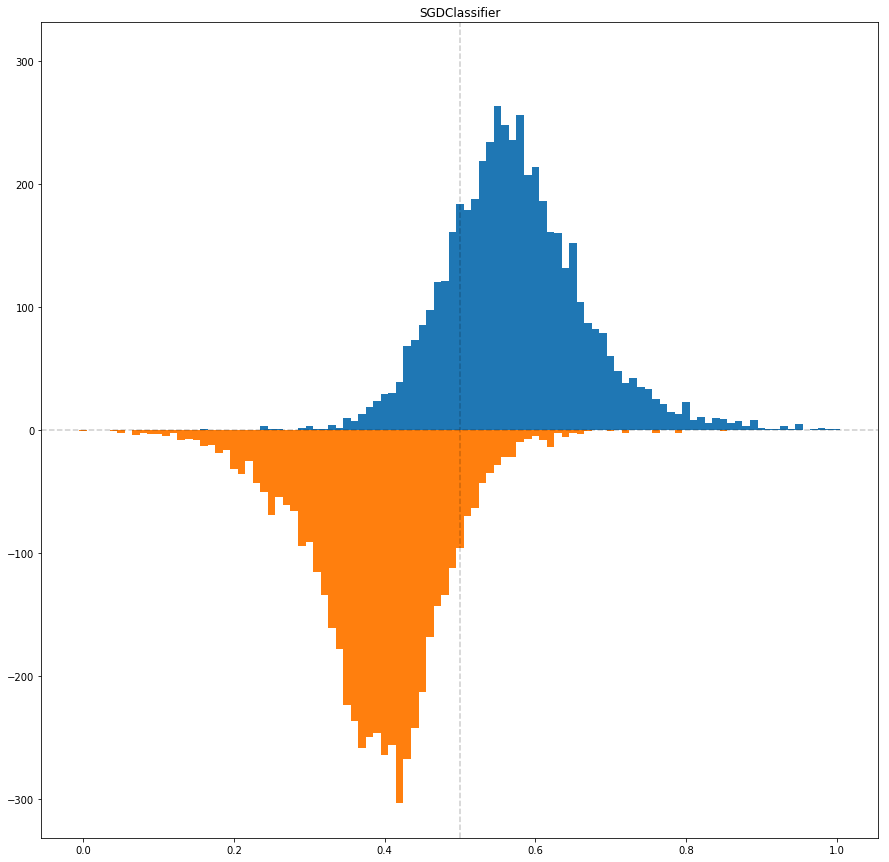

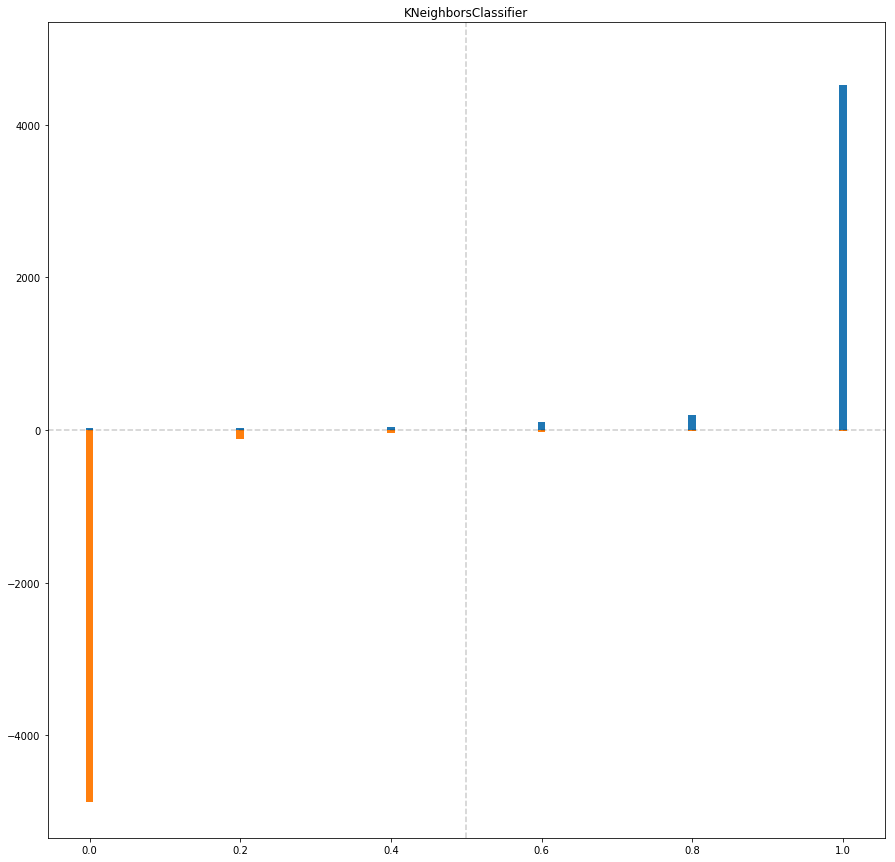

In [9]:
for i, (label, data) in enumerate(probs.iteritems()):
    plt.figure(i, figsize=(15,15))
    draw_datagram(data, actual)
    plt.title(label)
    plt.show()